# ELECTRA:
## PRE-TRAINING TEXT ENCODERSAS DISCRIMINATORS RATHER THAN GENERATORS

<style>
p {
  line-height: 1.6;
}
</style>
### 解决的问题：
**MLM(Masked language modeling)预训练的方法往往需要大量的算力：**  
<p>MLM(Masked language modeling )方式的预训练语言模型如BERT是在输入上用[MASK]遮蔽掉部分tokens，再训练一个模型以重建出原始的tokens。这种方式迁移到下游NLP任务时能够得到较好的结果，已然成为NLP任务中的标配。但是这种预训练的方法往往需要大量的算力。为此，本文提出一种更具样本效率的预训练任务——替换token检测(RTD)。RTD不对输入进行遮蔽，而是从生成网络中采样得到可信的tokens，再替换掉原始输入上的tokens。本文这里不再训练模型预测遭到破坏的输入中的tokens，而是训练一个判别器以辨别此时的输入中的每个token是否是生成器生成的。通过实验表明这种新的预训练任务比MLM更高效，这是由于该任务定义于全部的输入tokens，而非仅仅被遮蔽掉的那一部分小小的输入子集。实验结果表明本文方案所学习到的上下文表征大大优于相同模型大小、相同数据量和相同算力下的BERT。Small版的模型上收益更加显著，比如在GLUE自然语言理解基准上单块GPU上训练4天结果优于GPT(算力比其高30倍+)。本文的方法在规模上也是很有效，只使用RoBERTa和XLNet四分之一的算力即可得到可以比肩的结果，在使用相同算力的下可以超越对方。  
*（原文摘要部分）*</p>

### 具体实现方法：（原文Method部分）  
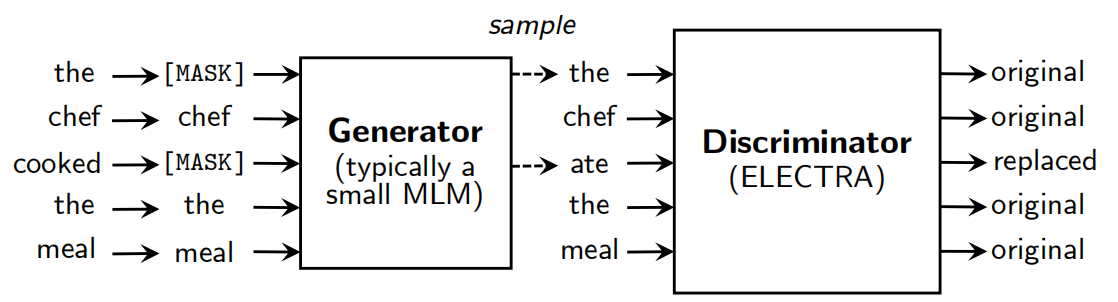  

训练两个神经网络分别是生成器G和判别器D，它们都包含 encoder ，**将输入的token序列$x=[x1,…,xn]$映射为一序列上下文表征向量$h(\boldsymbol{x})=\left[h_{1}, \ldots, h_{n}\right]$**。
给定位置t，生成器用softmax层输出$x_t$的概率分布：  
$$p_G(x_t∣x)=exp (e(x_t)^T  h_G(x)_t) / ∑_1^{x'} exp(e(x′)^T h_G(x)_t)$$  
其中e表示token的嵌入表征(token embeddings)。给定位置t，判别器预测token $x_t$是否是生成器生成的，其输出层是sigmoid：  
$$D(x, t) = sigmoid(w^T h_D(x)_t)$$
#### 概述：
* Generator执行MLM任务：给定输入列（语句被tokenize处理后的一组词）$x=[x_1, x_2, ..., x_n]$，MLM先选择一些随机的位置进行遮蔽，遮蔽集合为 $m = [m_1, ..., m_k]$，这些被选中的tokens被用[MASK] token替换，该操作定义为：
$$x_{masked} = REPLACE(x,m, [MASK])$$
* **生成器预测出被遮蔽的原始token**

* Discriminator任务：**鉴别出token是否是来自生成器**  
* 理解：通过用generator预测的masked token来代替原token，我们会得到有错误的（corrupted）集合 X ，从而我们可以通过discriminator是否判断出该token是replaced来对discriminator进行训练。模型根据以下式子重建输入：  
* $m_i\  ∼ unif\{1, n\} \ for \ i\ =\ 1 \ to \ k$:  
  $$x_{masked} = REPLACE(x,m, [MASK])$$
* $\widehat{x_i} ∼ p_G(x_i|x-{masked}) for\ i ∈ m$:
  $$x_{corrupt} = REPLACE(x,m, \widehat{x})



### 损失函数
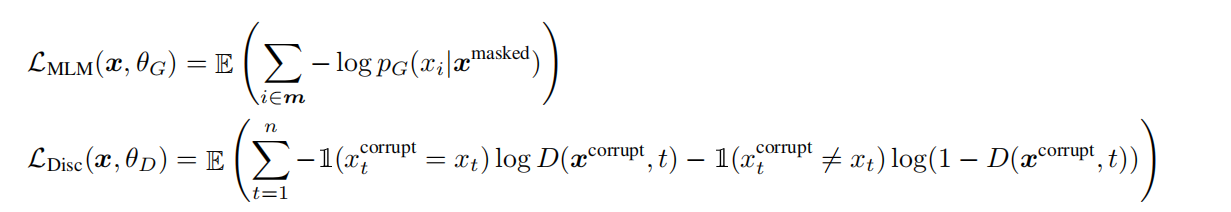

<style>
    p{
        line-height = 1.8
    }
</style>
### 与GAN（生成对抗模型）比较，不同点：

* <p>当生成器碰巧生成正确的token，则该token被视为真实的，而非假冒的。实验发现这种方式可以一定程度上地改善下游任务</p>
* <p>生成器的训练是基于最大似然而非对抗训练。后者企图在训练过程中骗过判别器。对抗训练在这里是很难实现，究其原因在于无法通过从生成器采样来进行反向传播。尽管本文也尝试使用强化学习的方式训练生成器从而绕开这个问题，但是效果仍不及最大似然的训练方式</p>
* <p>不像GAN那样在生成器的输入中添加噪声</p>


### 最终的联合损失：
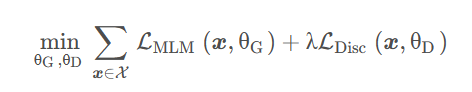
* 注：实验过程中用单样本来近似损失的期望。同时不把判别器的损失反向传播到生成器。在预训练之后，丢弃生成器，并在下游任务中对判别器进行微调。

## 关于实验（原文experiment部分）

### 实验设置：
为验证文本方法的有效性，在GLUE和SQuAD上进行实验。预训练数据集分两种情况：第一种是和BERT对比，则是采用Wikipedia 和 BooksCorpus数据集，合计大概3.3 Billion tokens；第二种是和XLNet对比，则与其相同的数据集进行预训练，即ClueWeb、CommonCrawl和Gigaword，合计33 Billion tokens。     
**（大量数据进行训练）**  

本文的模型架构和超参数总体上和BERT相同。在微调阶段，对于GLUE则在ELECTRA的顶部增加一个简单的线性分类器；对于SQuAD则借用XLNet中的问-答模块，将其加到ELECTRA的顶部。之所以这部分借用XLNet，是由于该模块比BERT更精细，起始位置和终点位置是联合预测的，而不像BERT那样两者各自独立，另外对于SQuAD2.0该模块还有能否回答的分类器。需要注意的是，一些评估数据集很小，这意味着微调模型的准确性可能会随着随机种子的不同而发生很大的变化。因此，最终报告结果是从相同的预先训练的检查点运行10次微调的中位数。

<style>
    p{
        line-height = 2.0
    }
</style>
### 对模型的进一步改善：
* **权重共享**：
    <p>  
    生成器和判别器权重参数共享可以提高预训练的效率。当生成器和判别器大小相同，则二者的所有transformer权重都可以密切相连。但是，实验中发现较小的生成器更为高效，这使得只能共享生成器和判别器的嵌入参数(包括token嵌入和位置嵌入)。这种情况下，使用的嵌入大小是根据判别器隐状态的嵌入尺寸。在生成器中添加一个线性变换层以将嵌入投射为生成器隐状态尺寸的表征。

    实验对比了，生成器和判别器相同大小的情况。在GLUE中，权重完全无关时得分为83.6，token 嵌入共享时得分为84.3，所有权重共享时得分为84.4。可以猜想本文的模型得益于token嵌入的共享方案，可能的原因是MLM在学习以下表征上尤为有效：

    * 仅当输入中有生成器生成的token时判别器才会更新。生成器的softmax在整个词典上密集更新所有的token嵌入。
    * 完全关联生成器和判别器的权重几乎没有什么提升，却需要生成器和判别器大小完全相同，这得不偿失。  
    
    基于上述这些发现，最终选用嵌入参数共享。
    </p>
* **较小的生成器**
  <p>
  如果生成器和判别器大小相同，则训练ELECTRA每步需要的计算量大约是只使用MLM训练的两倍。为此，本文使用较小的生成器以降低该因素的影响。具体是降低层的大小，同时保持其他超参数恒定不变。此外，本文还尝试了一个极简的unigram生成器，该生成器根据训练语料中的频率采样生成假的tokens。
  </p>
  

* **创新性的训练方法**
  <p>
  本文还进一步探索了ELECTRA的其他训练方法。尽管这些探索性工作并没有最终改善结果。探索的训练方法使用以下两阶段的训练流程：

  * 只训练生成器对应的损失函数为$\mathcal{L}_{\mathrm{MLM}}$，训练n步。
  * 用生成器的权重初始化判别器。再训练判别器(对应的损失函数是$\mathcal{L}_{\mathrm{Disc}}$，训练n步，同时固定住生成器的权重。  

  上述提到的权重初始化要求生成器和判别器的大小相同。实验中发现，如果判别器没有这个权重初始化操作，那么有时会甚至在大多数类之外学习失败。这可能是由于此时的生成器已远远领先于判别器。联合训练的方式另一方面天然地为判别器提供了一个总纲，在这个总纲中，生成器一开始很弱，但在整个训练过程中变得越来越好。此外本文还探索了如同GAN那般使用对抗方式训练生成器，具体使用强化学习来适应离散操作的采样生成器。

  对于两阶段的训练方法，当将生成目标转为判别目标后，下游任务的性能得到显著提升，但是最终没有超过联合训练方案。至于对抗训练方案，尽管超过了BERT，但是仍然逊色于最大似然训练方法。这之间的差距可能源于以下2个因素：
  * 对抗方式训练生成器在MLM上表现更差，只能取得58%的准确率，而最大似然的训练方案可以取得65%的准确率。准确率较差的主要原因是在生成文本的大动作空间中，强化学习的样本效率较低。
  * 对抗方式训练的生成器产生一个低熵输出分布，其中大部分概率集中在单个token上，这意味着生成器生成的样本中没有太多的多样性。
  </p>

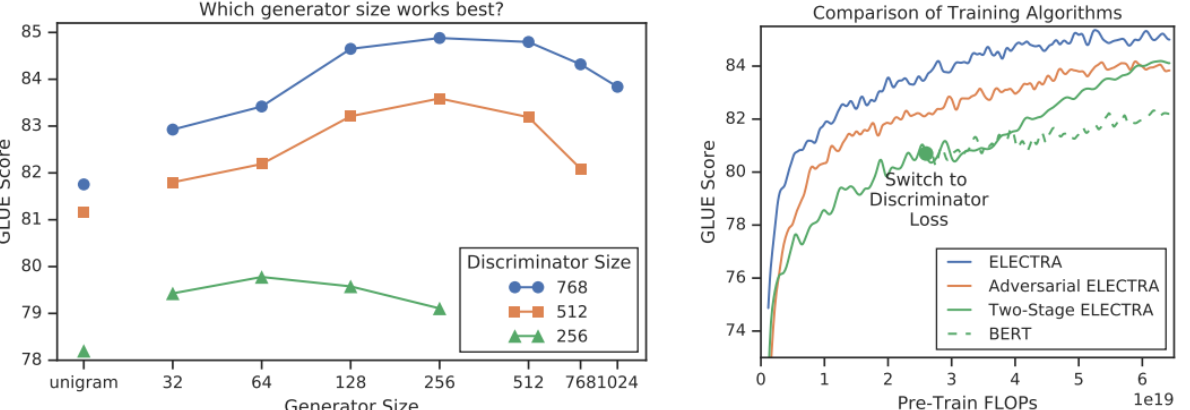
